## Nearest Neighbor

In [52]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state
from sklearn.metrics import accuracy_score

from nose.tools import assert_equal, assert_in, assert_is_not
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal, assert_index_equal

sns.set(style="white")

In [54]:
df = pd.read_csv('2001.csv', encoding='latin-1', usecols=(1, 2, 3, 5, 7, 15, 16, 18))

In [55]:
local = df[df['Origin'] == 'ORD']
local = local.drop('Origin', axis=1)
local['Delayed'] = (local['DepDelay'] >= 15).astype(np.int) 
local = local.drop('DepDelay', axis=1).dropna() 

In [56]:
print(local.head(5))

      Month  DayofMonth  DayOfWeek  CRSDepTime  CRSArrTime  Distance  Delayed
6367      1           1          1         951        1235       599        0
6368      1           2          2         951        1235       599        0
6369      1           3          3         951        1235       599        0
6370      1           4          4         951        1235       599        1
6371      1           5          5         951        1235       599        0


### Split

In [62]:
def split(df, test_column, test_size, random_state):
    '''
    Uses sklearn.train_test_split to split "df" into a testing set and a test set.
    The "test_columns" lists the column that we are trying to predict.
    All columns in "df" except "test_columns" will be used for training.
    The "test_size" should be between 0.0 and 1.0 and represents the proportion of the
    dataset to include in the test split.
    The "random_state" parameter is used in sklearn.train_test_split.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    test_columns: A list of strings
    test_size: A float
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    A 4-tuple of pandas.DataFrames
    '''
    
    x=df.drop(test_column, axis=1)
    y=df[test_column]
    (X_train, X_test, y_train, y_test) = train_test_split(x, y, test_size=test_size,random_state=random_state)
    return X_train, X_test, y_train, y_test

In [63]:
X_train_valid, X_test, y_train_valid, y_test = split(
    df=local,
    test_column=['Delayed'],
    test_size=0.2,
    random_state=check_random_state(0)
    )

In [64]:
assert_equal(isinstance(X_train_valid, pd.DataFrame), True)
assert_equal(isinstance(X_test, pd.DataFrame), True)
assert_equal(isinstance(y_train_valid, pd.DataFrame), True)
assert_equal(isinstance(y_test, pd.DataFrame), True)

assert_equal(len(X_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(X_test) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train_valid) - np.round(len(local) * 0.8) <= 1, True)
assert_equal(len(y_test) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train_valid.columns, local.columns.drop('Delayed'))
assert_index_equal(X_test.columns, local.columns.drop('Delayed'))
assert_equal(y_train_valid.columns, pd.Index(['Delayed']))
assert_equal(y_test.columns, pd.Index(['Delayed']))

In [65]:
X_train, X_valid, y_train, y_valid = split(
    df=X_train_valid.join(y_train_valid),
        test_column=['Delayed'],
    test_size=0.25,
    random_state=check_random_state(0)
    )

In [66]:
assert_equal(len(X_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)
assert_equal(len(y_train) - np.round(len(local) * 0.6) <= 1, True)
assert_equal(len(X_valid) - np.round(len(local) * 0.2) <= 1, True)

assert_index_equal(X_train.index[:5], pd.Int64Index([5903153, 1200840, 4524718, 2419368, 4017270]))
assert_index_equal(X_valid.index[:5], pd.Int64Index([722372, 3342898, 4673529,  896758, 1744337]))
assert_index_equal(y_train.index, X_train.index)
assert_index_equal(y_valid.index, X_valid.index)

### Normalize

In [67]:
print(local.min())

Month           1
DayofMonth      1
DayOfWeek       1
CRSDepTime    530
CRSArrTime      1
Distance       67
Delayed         0
dtype: int64


In [68]:
print(local.max())

Month           12
DayofMonth      31
DayOfWeek        7
CRSDepTime    2245
CRSArrTime    2359
Distance      4243
Delayed          1
dtype: int64


In [71]:
def normalize(df):
    '''
    Takes a dataframe and normlizes features to be in range [0, 1].
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame
    '''
    
    new=(df-df.min())/(df.max()-df.min())
    return new

In [72]:
X_train_normal, X_valid_normal = map(normalize, [X_train, X_valid])
print(X_train_normal.min())

Month         0.0
DayofMonth    0.0
DayOfWeek     0.0
CRSDepTime    0.0
CRSArrTime    0.0
Distance      0.0
dtype: float64


In [73]:
print(X_train_normal.max())

Month         1.0
DayofMonth    1.0
DayOfWeek     1.0
CRSDepTime    1.0
CRSArrTime    1.0
Distance      1.0
dtype: float64


In [74]:
df0 = pd.DataFrame({
    'a': [0, 1, 2, 3, 4],
    'b': [-50, -20, 10, 45, 50],
    'c': [-200, 450, 100, 500, -500]
    })

test1 = normalize(df0)
answer1 = pd.DataFrame({
    'a': [0., 0.25, 0.5, 0.75, 1.],
    'b': [0., 0.3, 0.6, 0.95, 1.],
    'c': [0.3, 0.95, 0.6, 1., 0.]
    })
assert_frame_equal(test1, answer1)

### Train a k-Nearest Neighbors model

In [77]:
def train_knn(X, y, n_neighbors):
    '''
    Fits a $k$-Nearest Neighbors on the training data.
    Returns the trained model (an `sklearn.neighbors.KNeighborsClassifier` object).
    
    Parameters
    ----------
    X: A pandas.DataFrame. Training attributes.
    y: A pandas.DataFrame. Truth labels.
    n_neighbors: Number of neighbors to use in kNN.
    
    Returns
    -------
    An sklearn.neighbors.KNeighborsClassifier object.
    '''
    
    knc = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knc.fit(X, y)
    return knc

In [78]:
test_X_train = pd.DataFrame({
    'a': np.random.rand(100),
    'b': np.random.rand(100)
    })
test_y_train = pd.DataFrame({
    'y': np.floor(np.random.rand(100) * 2)
    })

test2 = train_knn(test_X_train, test_y_train, 1)

assert_equal(isinstance(test2, neighbors.KNeighborsClassifier), True)
assert_equal(test2.n_neighbors, 1)
assert_array_almost_equal(test2._fit_X, test_X_train)
assert_array_equal(test2._y, test_y_train.values.ravel())

# test with different n_neighbors
test3 = train_knn(test_X_train, test_y_train, 5)
assert_equal(test3.n_neighbors, 5)
assert_array_almost_equal(test3._fit_X, test_X_train)
assert_array_equal(test3._y, test_y_train.values.ravel())

### Predict

In [91]:
def predict_knn(model, X):
    '''
    Fits an `sklearn.neighbors.KNeighborsClassifier` model on `X` and
    returns a `numpy.ndarray` of predicted values.
    
    Parameters
    ----------
    model: An sklearn.neighbors.KNeighborsClassifier object.
    X: pandas.DataFrame
    
    Returns
    -------
    A pandas.DataFrame. Has one column "Delayed".
    '''
    
    z = model.predict(X)
    prediction=pd.DataFrame(z,columns=['Delayed'])
    return prediction

In [92]:
test4_model = train_knn(X_train, y_train, 1)
test4 = predict_knn(test4_model, X_valid)[:10]
answer4 = pd.DataFrame({
    'Delayed': [1, 0, 0, 1, 0, 1, 0, 0, 1, 0]
    })

assert_equal(isinstance(test4, pd.DataFrame), True)
assert_frame_equal(test4, answer4)

test5_model = train_knn(X_train, y_train, 3)
test5 = predict_knn(test5_model, X_valid)[:10]
answer5 = pd.DataFrame({
    'Delayed': [1, 0, 1, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test5, answer5)

test6_model = train_knn(X_train, y_train, 5)
test6 = predict_knn(test6_model, X_valid)[:10]
answer6 = pd.DataFrame({
    'Delayed': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    })
assert_frame_equal(test6, answer6)

### Use accuracy to find the best model

In [102]:
def compute_accuracy(X_train, X_valid, y_train, y_valid, start=1, end=51):
    '''
    Find accuracy scores for kNN classifers
    with n_neighbors = start, start + 1, start + 2, ..., end - 1.
    Returns a Numpy array of length end - start.
    For example, if start=1 and end=4, then len(scores) = 3, and
    scores[0] cooresponds to the accuracy of kNN with k=1,
    scores[1] the accuracy of kNN with k=2, ..., and
    scores[2] the accuracy of KNN with k=3.
    
    
    Parameters
    ----------
    X_train: A pandas.DataFrame
    X_valid: A pandas.DataFrame
    y_train: A pandas.DataFrame
    y_valid: A pandas.DataFrame
    start: An int.
    end: An int.
    
    Returns
    -------
    A numpy.ndarray
    '''
    
    scores=np.empty(0)
    for nbrs in range(start,end):
        knc = neighbors.KNeighborsClassifier(n_neighbors=nbrs)
        knc.fit(X_train, y_train)
        score=knc.score(X_valid, y_valid)
        scores=np.append(scores,score)
    return scores

In [103]:
test6 = compute_accuracy(X_train, X_valid, y_train, y_valid, 2, 5)
assert_array_almost_equal(test6, [0.78034487, 0.74846536, 0.78298197])

In [104]:
scores = compute_accuracy(X_train, X_valid, y_train, y_valid, 1, 51)
k_best = np.argmax(scores) + 1
print('The best model: k = {}'.format(k_best))

The best model: k = 48


In [105]:
X_train_valid_normal, X_test_normal = map(normalize, [X_train_valid, X_test])

final_model = train_knn(X_train_valid_normal, y_train_valid, n_neighbors=k_best)
y_pred = predict_knn(final_model, X_test_normal)

accuracy = accuracy_score(y_test, y_pred)
print("The accuracy of k-Nearest Neighbors is {:2.1f}%.".format(accuracy * 100))

The accuracy of k-Nearest Neighbors is 82.0%.


### Confusion matrix

In [142]:
def plot_confusion(): 
    '''
    Plots a confusion matrix using numpy.histogram2d() and seaborn.heatmap().
    Returns a maptlotlib.axes.Axes instance.
    '''
    
    fig, ax = plt.subplots()
    names = ['Not delayed', 'Delayed']
    pts, xe, ye = np.histogram2d(np.array(y_test).flatten(), np.array(y_pred).flatten(), bins=2)
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    hm.axes.set_title('Confusion matrix for KNN (k=48)')
    return ax

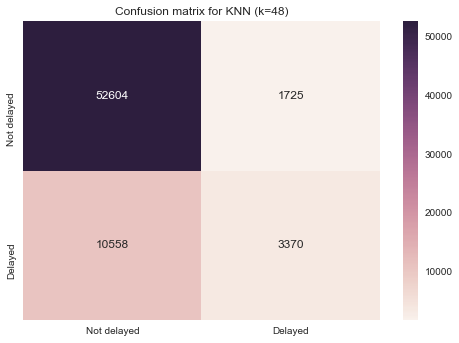

In [144]:
ax=plot_confusion()

In [145]:
assert_equal(isinstance(ax, mpl.axes.Axes), True, msg="Your function should return a matplotlib.axes.Axes object.")

texts = [t.get_text() for t in ax.texts]
assert_equal(texts, ['10558', '3370', '52604', '1725'])
             
x_tick_labels = [l.get_text() for l in ax.get_xticklabels()]
y_tick_labels = [l.get_text() for l in ax.get_yticklabels()]
assert_equal(y_tick_labels, ['Delayed', 'Not delayed'])

assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")